# Detect and Track Example

This notebook demonstrates detecting and tracking objects in a video stream.

---

## Preparation

### Install dependencies

First, we need to install & import the necessary packages.

In [1]:
!pip install --quiet -e ../../ # if you haven't installed soccertrack

%load_ext autoreload
%autoreload 2

    ERROR: Command errored out with exit status 1:
     command: /opt/anaconda3/envs/base_atom/bin/python -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/home/atom/soccertrack/setup.py'"'"'; __file__='"'"'/home/atom/soccertrack/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-y2x0329i
         cwd: /home/atom/soccertrack/
    Complete output (23 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/home/atom/soccertrack/setup.py", line 10, in <module>
        setup(
      File "/opt/anaconda3/envs/base_atom/lib/python3.8/site-packages/setuptools/__init__.py", line 153, in setup
        return distutils.core.setup(**attrs)
      File "/opt/anaconda3/envs/base_

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np

from rich import inspect
from soccertrack.detect import detect_objects
from soccertrack.utils import load_config, merge_dict_of_lists, logger, set_log_level
from soccertrack.utils.camera import load_cameras
from soccertrack.viz import visualize_cameras, visualize_cameras_to_pitch

from soccertrack.utils.tracking import Track, GatedEuclideanDistance
from soccertrack.kfs import kinematic_kf, parabolic_kf


ImportError: cannot import name 'parabolic_kf' from 'soccertrack.kfs' (/home/atom/soccertrack/soccertrack/kfs.py)

### Create a yaml file

SoccerTrack relies on one large configuration file to run. This file contains all the necessary information to run the perform detection and tracking. See the [detect_and_track.yaml](detect_and_track.yaml) file for an example. 

In [ ]:
cfg = load_config('./detect_and_track.yaml')

```python
>>> inspect(cfg) 
╭──────────────────────── <class 'omegaconf.dictconfig.DictConfig'> ────────────────────────╮
│ ╭───────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ {'cameras': [{'label': 'left', 'video_path': '../../data/raw/left_camera.mp4',        │ │
│ │ 'keypoint_xml': '../../data/raw/left_keypoints.xml', 'calibration_video_path':        │ │
│ │ '../../data/raw/left_checkerboard_images/', 'x_range': [0, 52.5], 'y_range': [0, 68], │ │
│ │ 'camera_matrix': None, 'camera_matrix_path': None, 'distortion_coefficients': None,   │ │
│ │ 'distortion_coefficients_path': None}, {'label': 'right', 'video_path':               │ │
│ │ '../../data/raw/right_camera.mp4', 'keypoint_xml':                                    │ │
│ │ '../../data/raw/right_keypoints.xml', 'calibration_video_path':                       │ │
│ │ '../../data/raw/right_checkerboard_images/', 'x_range': [52.5, 105], 'y_range': [0,   │ │
│ │ 68], 'camera_matrix': None, 'camera_matrix_path': None, 'distortion_coefficients':    │ │
│ │ None, 'distortion_coefficients_path': None}], 'detection': {'model_name': 'yolov5x',  │ │
│ │ 'size': 3000, 'batch_size': 32}, 'outdir': '../../data/processed/'}                   │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│   cameras = [{'label': 'left', 'video_path': '../../data/raw/left_camera.mp4',            │
│             'keypoint_xml': '../../data/raw/left_keypoints.xml',                          │
│             'calibration_video_path': '../../data/raw/left_checkerboard_images/',         │
│             'x_range': [0, 52.5], 'y_range': [0, 68], 'camera_matrix': None,              │
│             'camera_matrix_path': None, 'distortion_coefficients': None,                  │
│             'distortion_coefficients_path': None}, {'label': 'right', 'video_path':       │
│             '../../data/raw/right_camera.mp4', 'keypoint_xml':                            │
│             '../../data/raw/right_keypoints.xml', 'calibration_video_path':               │
│             '../../data/raw/right_checkerboard_images/', 'x_range': [52.5, 105],          │
│             'y_range': [0, 68], 'camera_matrix': None, 'camera_matrix_path': None,        │
│             'distortion_coefficients': None, 'distortion_coefficients_path': None}]       │
│ detection = {'model_name': 'yolov5x', 'size': 3000, 'batch_size': 32}                     │
│    outdir = '../../data/processed/'                                                       │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
```

## Camera setup

SoccerTrack is designed to use either a single camera or multiple cameras. In this example we will use a two camera setup. 

For each camera the following information is required in the yaml file:

* `label` - a unique label for the camera. Either `Left` or `Right` is used in this example.
* `video_path` - The path to the video file.
* `keypoint_xml` - The path to the xml file containing the keypoints.
* `calibration_video_path` - The path to the video file used for calibration.
* `x_range` - The x range of the camera.
* `y_range` - The y range of the camera.
* `camera_matrix` - The camera matrix of the camera.
* `camera_matrix_path` - The path to the camera matrix file.
* `distortion_coefficients` - The distortion coefficients of the camera.
* `distortion_coefficients_path` - The path to the distortion coefficients file.


Note that usually a multicamera setup can be used to drastically improve the performance of the tracking by methods such as triangulation. However, this is not implemented yet.

### Defining the camera ranges

First, the range that each camera is resposible for handling detections for is defined. This is done by defining the x and y ranges in the yaml file.

![](imgs/cam_area.png)

In the example above, the `Blue Cam` is responsible for the x range from 0~52.5 and the `Red Cam` is responsible for the x range from 52.5~105. The y range is defined as the same, 0~68, for both cameras.

In the yaml file this will be defined as:

```yaml
- label: Blue Cam
  x_range:
  - 0
  - 52.5
  y_range:
  - 0
  - 68

- label: Red Cam
  x_range:
  - 52.5
  - 105
  y_range:
  - 0
  - 68

```
Although not at all perfect, this setup allows the number of cameras to be increased to multiple cameras or decresed to one wide angle camera.

### Camera calibration

In order to reduce the distortion of the camera lense and straighten the lines of pitch, the camera is calibrated. This is done by using a video or a set of images containing a checkboard pattern from multiple angles.

![](imgs/cam_calibration.png)

Record a short video of the checkboard pattern and add the path to the yaml file.

### Homography Transformation

TODO: This section needs its own notebook.

![](imgs/cam_keypoints.png)

### Load the camera objects

Most of the information above (camera ranges, calibration, homography matrix etc.) is specific to the camera. Therefore it makes sense to create a `Camera` object to store this information. Below is an example of how to create a `Camera` object.

For more detail on what the `Camera` object does, read the documentation of the `Camera` class.

In [ ]:
cameras = load_cameras(cfg['cameras'])
print(f"Loaded {len(cameras)} cameras")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loaded 2 cameras


```python
>>> inspect(cameras[0])
╭──────────────────────── <class 'soccertrack.utils.camera.Camera'> ────────────────────────╮
│ ╭───────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ <soccertrack.utils.camera.Camera object at 0x7fa4d4216a90>                            │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│                            A = array([[ 5.15339114e-02, -2.48630620e-03,                  │
│                                -6.16015294e+01],                                          │
│                                       [ 2.48630620e-03,  5.15339114e-02,                  │
│                                -3.25664812e+01]])                                         │
│                camera_matrix = array([[2.15613802e+03, 0.00000000e+00, 1.56562954e+03],   │
│                                       [0.00000000e+00, 2.16032276e+03, 8.93321528e+02],   │
│                                       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])  │
│           camera_matrix_path = '../../data/raw/left_checkerboard_images/.camera_matrix.n… │
│      distortion_coefficients = array([[-3.86993200e-01,  1.81587334e-01,  3.38269313e-04, │
│                                        -3.88791413e-03, -5.07126929e-02]])                │
│ distortion_coefficients_path = '../../data/raw/left_checkerboard_images/.distortion_coef… │
│                            H = array([[-1.96203042e-02, -8.58525820e-02,                  │
│                                7.49647876e+01],                                           │
│                                       [-7.00875850e-03, -1.43839641e-01,                  │
│                                9.09678263e+01],                                           │
│                                       [-1.68005463e-04, -1.70170553e-03,                  │
│                                1.00000000e+00]])                                          │
│                            h = 1728                                                       │
│                 keypoint_map = {                                                          │
│                                    (16.5, 0.0): array([1558.26162222,  555.72213685]),    │
│                                    (49.5, 68.0): array([2052.63260037, 1145.72850178]),   │
│                                    (22.0, 68.0): array([573.62124085, 906.77437939]),     │
│                                    (0.0, 24.84): array([1110.73109074,  619.81784405]),   │
│                                    (33.0, 68.0): array([938.49757603, 966.48531504]),     │
│                                    (52.5, 0.0): array([2254.59956961,  523.43397107]),    │
│                                    (16.5, 53.16): array([899.34001553, 746.46366605]),    │
│                                    (16.5, 14.84): array([1462.75472983,  583.12588009]),  │
│                                    (5.5, 0.0): array([1407.31178303,  563.57990178]),     │
│                                    (0.0, 37.66): array([929.43635375, 660.83062687]),     │
│                                    (11.0, 68.0): array([328.58590272, 867.16789754]),     │
│                                    (0.0, 34.0): array([987.43317652, 648.36081735]),      │
│                                    (5.5, 43.16): array([923.01686172, 681.50776995]),     │
│                                    (44.0, 0.0): array([2055.2764852,  532.2939888]),      │
│                                    (44.0, 68.0): array([1559.08634969, 1065.80217245]),   │
│                                    (5.5, 24.84): array([1181.33105706,  618.10274965]),   │
│                                    (0.0, 0.0): array([1339.90056291,  567.68426233]),     │
│                                    (38.5, 0.0): array([1938.93543248,  538.0430888 ]),    │
│                                    (0.0, 30.34): array([1038.72029834,  636.09482872]),   │
│                                    (0.0, 53.16): array([604.76341502, 735.86943365]),     │
│                                    (33.0, 0.0): array([1835.62452131,  544.03354279]),    │
│                                    (52.5, 68.0): array([2431.72442695, 1206.94940776]),   │
│                                    (0.0, 68.0): array([158.04929436, 838.95902402]),      │
│                                    (38.5, 68.0): array([1201.58445867, 1009.34630455]),   │
│                                    (49.5, 0.0): array([2177.025495  ,  527.01023073]),    │
│                                    (27.5, 68.0): array([736.2702491 , 933.62312459]),     │
│                                    (27.5, 0.0): array([1734.56353984,  548.81036346]),    │
│                                    (16.5, 68.0): array([442.52805887, 884.849372  ]),     │
│                                    (22.0, 0.0): array([1640.25520571,  552.80049224]),    │
│                                    (52.5, 34.0): array([2281.94690316,  622.75123723]),   │
│                                    (55.5, 0.0): array([2333.55841905,  519.20666754]),    │
│                                    (52.5, 24.85): array([2271.68945831,  585.09609849]),  │
│                                    (52.5, 43.15): array([2296.5896004 ,  682.93037444]),  │
│                                    (0.0, 14.84): array([1224.9466838 ,  593.59923437]),   │
│                                    (11.0, 0.0): array([1477.78286547,  561.11471057]),    │
│                                    (5.5, 68.0): array([236.43958477, 852.09260608]),      │
│                                    (0.0, 43.16): array([841.73876446, 681.52686758]),     │
│                                    (61.0, 0.0): array([2489.25741953,  511.42404629])     │
│                                }                                                          │
│                        label = 'left'                                                     │
│             source_keypoints = array([[1558.26162222,  555.72213685],                     │
│                                       [2052.63260037, 1145.72850178],                     │
│                                       [ 573.62124085,  906.77437939],                     │
│                                       [1110.73109074,  619.81784405],                     │
│                                       [ 938.49757603,  966.48531504],                     │
│                                       [2254.59956961,  523.43397107],                     │
│                                       [ 899.34001553,  746.46366605],                     │
│                                       [1462.75472983,  583.12588009],                     │
│                                       [1407.31178303,  563.57990178],                     │
│                                       [ 929.43635375,  660.83062687],                     │
│                                       [ 328.58590272,  867.16789754],                     │
│                                       [ 987.43317652,  648.36081735],                     │
│                                       [ 923.01686172,  681.50776995],                     │
│                                       [2055.2764852 ,  532.2939888 ],                     │
│                                       [1559.08634969, 1065.80217245],                     │
│                                       [1181.33105706,  618.10274965],                     │
│                                       [1339.90056291,  567.68426233],                     │
│                                       [1938.93543248,  538.0430888 ],                     │
│                                       [1038.72029834,  636.09482872],                     │
│                                       [ 604.76341502,  735.86943365],                     │
│                                       [1835.62452131,  544.03354279],                     │
│                                       [2431.72442695, 1206.94940776],                     │
│                                       [ 158.04929436,  838.95902402],                     │
│                                       [1201.58445867, 1009.34630455],                     │
│                                       [2177.025495  ,  527.01023073],                     │
│                                       [ 736.2702491 ,  933.62312459],                     │
│                                       [1734.56353984,  548.81036346],                     │
│                                       [ 442.52805887,  884.849372  ],                     │
│                                       [1640.25520571,  552.80049224],                     │
│                                       [2281.94690316,  622.75123723],                     │
│                                       [2333.55841905,  519.20666754],                     │
│                                       [2271.68945831,  585.09609849],                     │
│                                       [2296.5896004 ,  682.93037444],                     │
│                                       [1224.9466838 ,  593.59923437],                     │
│                                       [1477.78286547,  561.11471057],                     │
│                                       [ 236.43958477,  852.09260608],                     │
│                                       [ 841.73876446,  681.52686758],                     │
│                                       [2489.25741953,  511.42404629]])                    │
│             target_keypoints = array([[16.5 ,  0.  ],                                     │
│                                       [49.5 , 68.  ],                                     │
│                                       [22.  , 68.  ],                                     │
│                                       [ 0.  , 24.84],                                     │
│                                       [33.  , 68.  ],                                     │
│                                       [52.5 ,  0.  ],                                     │
│                                       [16.5 , 53.16],                                     │
│                                       [16.5 , 14.84],                                     │
│                                       [ 5.5 ,  0.  ],                                     │
│                                       [ 0.  , 37.66],                                     │
│                                       [11.  , 68.  ],                                     │
│                                       [ 0.  , 34.  ],                                     │
│                                       [ 5.5 , 43.16],                                     │
│                                       [44.  ,  0.  ],                                     │
│                                       [44.  , 68.  ],                                     │
│                                       [ 5.5 , 24.84],                                     │
│                                       [ 0.  ,  0.  ],                                     │
│                                       [38.5 ,  0.  ],                                     │
│                                       [ 0.  , 30.34],                                     │
│                                       [ 0.  , 53.16],                                     │
│                                       [33.  ,  0.  ],                                     │
│                                       [52.5 , 68.  ],                                     │
│                                       [ 0.  , 68.  ],                                     │
│                                       [38.5 , 68.  ],                                     │
│                                       [49.5 ,  0.  ],                                     │
│                                       [27.5 , 68.  ],                                     │
│                                       [27.5 ,  0.  ],                                     │
│                                       [16.5 , 68.  ],                                     │
│                                       [22.  ,  0.  ],                                     │
│                                       [52.5 , 34.  ],                                     │
│                                       [55.5 ,  0.  ],                                     │
│                                       [52.5 , 24.85],                                     │
│                                       [52.5 , 43.15],                                     │
│                                       [ 0.  , 14.84],                                     │
│                                       [11.  ,  0.  ],                                     │
│                                       [ 5.5 , 68.  ],                                     │
│                                       [ 0.  , 43.16],                                     │
│                                       [61.  ,  0.  ]])                                    │
│                    video_fps = 25                                                         │
│                   video_path = '../../data/raw/left_camera.mp4'                           │
│                            w = 3072                                                       │
│                      x_range = [0, 52.5]                                                  │
│                      y_range = [0, 68]                                                    │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
```

---

## Detection

### Detection with [YOLOv5](https://github.com/ultralytics/yolov5)

Although any object detection model can be used, [YOLOv5](https://github.com/ultralytics/yolov5) is very is easy to perform training and inference.

It is a state-of-the-art object detection model that is trained on the [COCO dataset](http://cocodataset.org/) and has been shown to achieve state-of-the-art results on COCO. 

In SoccerTrack, a wrapper is used to load the YOLOv5 model and perform detection. For more details, please refer to the documentation on `detect_objects`.

In [6]:
player_detections, ball_detections = detect_objects(
    cameras,
    model_name=cfg.detection.model_name,
    size=cfg.detection.size,
    batch_size=cfg.detection.batch_size,
    filter_range=cfg.detection.filter_range,
)

print("N ball detections:", sum(len(x) for x in ball_detections.values()))
print("N player detections:", sum(len(x) for x in player_detections.values()))

Using cache found in /home/atom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-12-28 torch 1.10.0+cu102 CUDA:0 (GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model Summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

N ball detections: 175
N player detections: 5206


### Visualize detections

SoccerTrack provides a few tools for visualization. In this example we will use the `visualize_detections` to visualize the detections in a clean grid. 

In [7]:
set_log_level("INFO")

all_candidate_detections = merge_dict_of_lists(ball_detections, player_detections)

visualize_cameras(
    cameras=cameras,
    save_dir=cfg.outdir,
    candidate_detections=all_candidate_detections,
    auto_grid=True,
    height=200
)

# See the link below for the outputs
# https://github.com/AtomScott/SoccerTrack/tree/main/data/processed

# from IPython.display import Video
# Video(os.path.join(cfg.outdir, "grid.mp4"))

visualize_cameras:56	💬| Visualizing camera left
visualize_cameras:56	💬| Visualizing camera right
visualize_cameras:70	💬| Auto-generating video of shape 1x2
visualize_cameras:107	💬| Saving video to ../../data/processed/grid.mp4


In [8]:
visualize_cameras_to_pitch(
    cameras=cameras,
    save_path=os.path.join(cfg.outdir, "pitch.mp4"),
    candidate_detections=all_candidate_detections,
    height=200,
    plot_keypoints = True,
)

# See the link below for the outputs
# https://github.com/AtomScott/SoccerTrack/tree/main/data/processed

# Video(os.path.join(cfg.outdir, "pitch.mp4"))

## Ball Trajectory Reconstruction

Reconstructing the trajetory of a ball from detections from a video is an fundamentally ill posed problem. 
If the ball is in the air, a simple homography transformation is not enough to calculate the location of the ball on the pitch plane. 

Below is an example of such a trajectory.

In [9]:
%matplotlib inline

from IPython.display import Video
from soccertrack.viz import get_xsys
from mplsoccer import Pitch

visualize_cameras_to_pitch(
    cameras=cameras,
    save_path=os.path.join(cfg.outdir, "pitch_ball.mp4"),
    candidate_detections=ball_detections,
    height=200,
    in_range=False,
    plot_keypoints = False,
    afterimage=15,
)

Video(os.path.join(cfg.outdir, "pitch_ball.mp4"))

A simple method to reconstruct the trajectory is to apply the trajectories to a kalman filter. In SoccerTrack, the baseline model is a special Kalman Filter called Interacting Multiple Models (IMM). A clean explanation of IMM can be found in the [filterpy book](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/14-Adaptive-Filtering.ipynb).

The idea of IMM is to have 1 filter for each possible mode of behavior of the system. For example, we have the following modes for ball tracking:
* Linear motion model
* Parabolic motion model


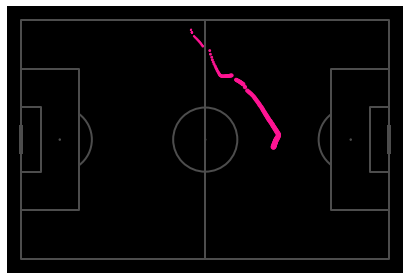

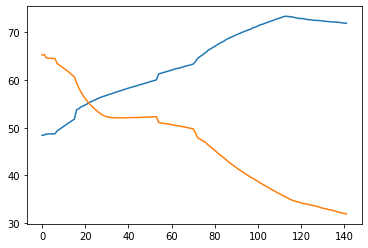

Text(0.5, 1.0, 'probability ratio p(cv)/p(ca)')

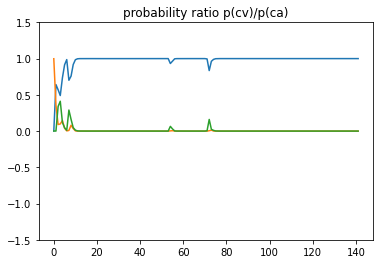

In [106]:
from filterpy.common import Q_discrete_white_noise, Saver
from filterpy.kalman import IMMEstimator
from soccertrack.utils.tracking import GatedEuclideanDistance
from soccertrack.kfs import kinematic_kf_ord1, kinematic_kf_ord2, kinematic_kf_ord3



euclidean_distance = GatedEuclideanDistance(max_limit=10)

not_init = True
for frame_idx in range(len(ball_detections)):
    detections = ball_detections.get(frame_idx, [])

    # catch first detection
    if not_init and len(detections) > 0:
        dt = cameras[0].fps
        kf_ord1 = kinematic_kf_ord1(10, 1, 10, dt)
        kf_ord2 = kinematic_kf_ord2(10, 1, 10, dt)
        kf_ord3 = kinematic_kf_ord3(10, 1, 10, dt)
        filters = [kf_ord1, kf_ord2, kf_ord3]

        M = np.array([[0.49, 0.02, 0.49], [0.02, 0.49, 0.49], [0.49, 0.49, 0.02]])
        mu = np.array([0.4, 0.4, 0.3])

        imm = IMMEstimator(filters, mu, M)
        track = Track(
            initial_detection=detections[0], kf=imm, funcs=[euclidean_distance]
        )  # constant velocity model
        not_init = False

    # if no detections have been found yet, continue
    if not_init:
        continue

    # assocation step
    detection, cost = track.associate(detections, return_cost=True)
    # logger.info(f"Association cost: {cost}")

    # prediction step
    track.predict()

    if detection is None:
        # no association
        continue

    # update step
    track.update(detection)

visualize_cameras_to_pitch(
    cameras=cameras,
    save_path=os.path.join(cfg.outdir, "pitch_ball.mp4"),
    candidate_detections={k:[v] for k,v in enumerate(track.detections)},
    height=200,
    in_range=False,
    plot_keypoints = False,
    afterimage=15,
)


xs, ys = np.squeeze(np.array(track.saver.x)[:, [0, 4]]).T

pitch = Pitch(
    pitch_color="black",
    line_color=(0.3, 0.3, 0.3),
    pitch_type="custom",
    pitch_length=105,
    pitch_width=68,
)
fig, ax = pitch.draw()
plt.scatter(xs, ys, color="deeppink", s=np.linspace(1, 20, len(xs)))
plt.show()

plt.plot(xs)
plt.plot(ys)
plt.show()

probs = np.array(track.saver.mu)
plt.plot(probs[:, 0])
plt.plot(probs[:, 1])
plt.plot(probs[:, 2])
plt.ylim(-1.5, 1.5)
plt.title("probability ratio p(cv)/p(ca)")


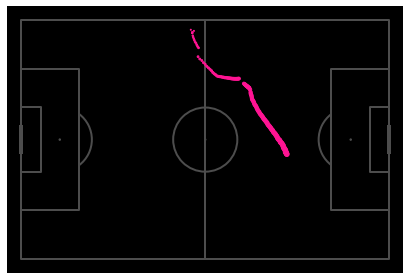

In [ ]:
from filterpy.common import Q_discrete_white_noise, Saver, kinematic_kf
from filterpy.kalman import IMMEstimator

from soccertrack.utils.tracking import Track, EuclideanDistance

# filter ball where in_range is False
ball_detections_ir = {
    k: [vi for vi in v if vi.in_range] for k, v in ball_detections.items()
}

euclidean_distance = EuclideanDistance()

not_init = True
for frame_idx in range(len(ball_detections_ir)):
    detections = ball_detections_ir.get(frame_idx, [])
    
    # catch first detection
    if not_init and len(detections) > 0:
        kf = kinematic_kf(dim=2, order=1, dt=cameras[0].fps)
        kf.Q = Q_discrete_white_noise(dim=kf.Q.shape[0], var=0.10)
        kf.R *= 0.1
        track = Track(
            initial_detection=detections[0], kf=kf, funcs=[euclidean_distance]
        )  # constant velocity model
        not_init = False
    
    if not_init:
        continue

    # assocation step
    detection, cost = track.associate(detections, return_cost=True)

    # prediction step
    track.predict()

    if detection is None:
        # no association
        continue

    # update step
    track.update(detection)

xs, ys = np.squeeze(np.array(track.saver.x)[:, [0, 2]]).T

pitch = Pitch(pitch_color='black', line_color=(.3,.3,.3), pitch_type='custom', pitch_length=105, pitch_width=68) 
fig, ax = pitch.draw()
plt.scatter(xs, ys, color='deeppink', s=np.linspace(1, 20, len(xs)))
plt.show()

In [ ]:
from scipy.spatial.distance import cdist, euclidean
from scipy.optimize import linear_sum_assignment

from soccertrack.utils.tracking import Track
from soccertrack.utils import logger

def cost(X, Y, feature, func):
    x_feature = getattr(X, '_feature_'+feature)
    y_feature = getattr(Y, '_feature_'+feature)
    return func(x_feature, y_feature)

def cdist(detections, tracks, funcs, reduction='mean'):
    
    costs = []
    for func in funcs:
        C = np.zeros((len(detections), len(tracks)))

        for di, detection in enumerate(detections):
            for ti, track in enumerate(tracks):
                C[di, ti] = cost(detection, track, feature='xy', func=func)
        costs.append(C)
            
    if reduction == 'mean':
        return np.mean(costs, axis=0)
    else:
        raise NotImplementedError(f"reduction(`{reduction}`) not implemented")



array([[     76.799,      57.867],
       [     79.688,      60.495],
       [     73.396,      57.882]])

In [ ]:
inspect(detections[0]._class_id)

detections = ball_detections[0]
tracks = [Track(0,0), Track(32,14)]
cdist(detections, tracks, funcs=[euclidean])

╭────── <class 'int'> ───────╮
│ int([x]) -> integer        │
│ int(x, base=10) -> integer │
│                            │
│ ╭────────────────────────╮ │
│ │ 32                     │ │
│ ╰────────────────────────╯ │
│                            │
│ denominator = 1            │
│        imag = 0            │
│   numerator = 32           │
│        real = 32           │
╰────────────────────────────╯

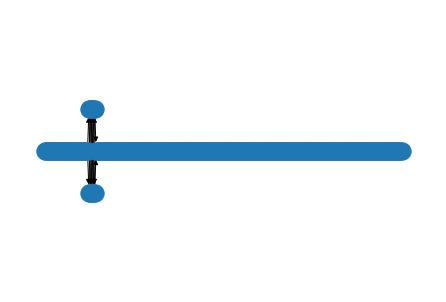

In [ ]:
import networkx as nx

def calculate_weight(n1, n2):
    return np.random.randint(1, 10, 1)


# Generate Graph
G = nx.DiGraph(capacity=1)

timesteps = range(max(ball_detections.keys()))
G.add_node('start', frame_idx=-1, class_id=-1)
previous_nodes = ['start']

min_detections = 1
for timestep in timesteps:
    next_nodes = []
    detections = [detection for detection in ball_detections[timestep] if detection.in_range]

    for di, detection in enumerate(detections):
        assert detection.frame_idx == timestep, (detection.frame_idx, timestep)

        node_id = f"{detection.frame_idx}_{di}_{detection.camera.label}_{detection._class_id}"
        G.add_node(node_id, frame_idx=timestep, class_id = detection._class_id)
        next_nodes.append(node_id)

        for prev_node in previous_nodes:
            G.add_edge(prev_node, node_id, weight=calculate_weight(G.nodes[prev_node], G.nodes[node_id]))

    if len(detections) < min_detections:
        for pi in range(min_detections - len(detections)):
            node_id = f"placeholder_{timestep}_{pi}"
            G.add_node(node_id, frame_idx=timestep, class_id = -1)
            next_nodes.append(node_id)

            for prev_node in previous_nodes:
                G.add_edge(prev_node, node_id, weight=calculate_weight(G.nodes[prev_node], G.nodes[node_id]))
    
    previous_nodes = next_nodes
    
G.add_node('end', frame_idx=timestep+1, class_id=-1)
for prev_node in previous_nodes:
    G.add_edge(prev_node, 'end', weight=calculate_weight(G.nodes[prev_node], G.nodes[node_id]))


pos = nx.multipartite_layout(G, subset_key='frame_idx')
nx.draw(G, pos)

flow_dict = nx.min_cost_flow(G)



In [ ]:

funcs=[euclidean]
timesteps = list(ball_detections.keys())
for timestep in timesteps:
    detections = ball_detections[timestep]

    # initialize trackers
    if timestep == 0:
        tracks = [Track(34) for _ in detections]

    # generate cost matrix
    cost_matrix = cdist(detections, tracks, funcs)

    # calculate hungarian assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # update tracks
    for di, ti in zip(row_ind, col_ind):
        if timestep != 0:
            logger.debug(f"{detections[di]._feature_xy} -> {tracks[ti].detections[-1]._feature_xy}")
        tracks[ti].detections.append(detections[di])


IndexError: list index out of range

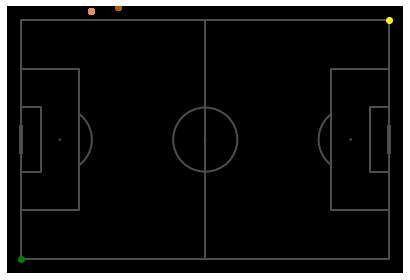

In [ ]:
# before pitch reconstruction
pitch = Pitch(pitch_color='black', line_color=(.3,.3,.3), pitch_type='custom', pitch_length=105, pitch_width=68) 
fig, ax = pitch.draw()

for track in tracks:
    xs, ys = get_xsys(track.detections, cameras)
    plt.scatter(xs, ys, color=np.random.rand(3,))

plt.scatter(0,0, color='green')
plt.scatter(105,68, color='yellow')

In [ ]:
df = pd.concat(df_list) # necessary for restart
df = df.sort_values('frame') 

# ball trajectory reconstruction
xs, ys, ts = df[(df['name']=='sports ball') & (df['confidence']>=.5) & (df['drop']==False)][['x', 'y', 'frame']].values.T

ts_range = range(int(ts[0]), int(ts[-1]+2))
xs2 = [np.nan for _ in ts_range]
ys2 = [np.nan for _ in ts_range]

for i, _ in enumerate(ts):
    xs2[int(ts[i])] = xs[i]
    ys2[int(ts[i])] = ys[i]
    
xs = np.array(xs2)
ys = np.array(ys2)

for _ in range(3):
    xs = fill_nan(xs)
    ys = fill_nan(ys)
    ds = np.sqrt(np.diff(xs, 1, append=xs[-1:]) ** 2 + np.diff(ys, 1, append=ys[-1:]) ** 2)
    
    xs = smooth(xs, 3)
    ys = smooth(ys, 3)
    ds = smooth(ds, 3)
    xs[ds>1.] = np.nan
    ys[ds>1.] = np.nan

    xs = fill_nan(xs)
    ys = fill_nan(ys)

# try to update main dataframe
for t in tqdm(ts_range):
    if len(df.loc[(df['name']=='sports ball') & (df['drop']==False) & (df['frame']==t)]) == 0:
        df = df.append([{
            'name':'sports ball',
            'drop':False,
            'frame':t,
            'x': xs[t],
            'y': ys[t]
        }])
    else:
        # dupes r fuk
        df.loc[(df['name']=='sports ball') & (df['drop']==False) & (df['frame']==t), 'x'] = xs[t]
        df.loc[(df['name']=='sports ball') & (df['drop']==False) & (df['frame']==t), 'y'] = ys[t]

## Tracking